In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.vision import *
from fastai.callbacks.hooks import *
from fastai.callbacks import *
from fastai.vision.interpret import *
torch.cuda.set_device(1)

In [3]:
train_img = './augmented/train/imgs'
train_mask = './augmented/train/masks'
codes = ['road','background']
img_size = 1024
bs = 1
wd=1e-2

In [4]:
get_lbl_train = lambda x: train_mask+f'/{x.stem}{x.suffix}'
class SegLabelListCustom(SegmentationLabelList):
    def open(self, fn): return open_mask(fn, div=True)
    
class SegItemListCustom(ImageList):
    _label_cls = SegLabelListCustom

In [5]:
src = (SegItemListCustom.from_folder(train_img).split_by_rand_pct(0.2)
       .label_from_func(get_lbl_train, classes=codes))

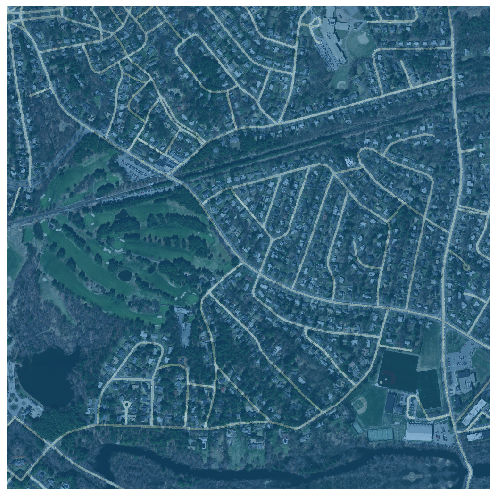

In [16]:
data = (src.transform(get_transforms(), size=img_size, tfm_y=True).databunch(bs=bs).normalize())
data.show_batch(3, figsize=(10,7))

In [6]:
def accuracy(input_img, target):
    target = target.squeeze(1)
    return (input_img.argmax(dim=1)==target).float().mean()

def iou(input_img, target):
    return dice(input_img, target, iou=True)

# Stage 1: Train a UNet with resnet101 backbone and self-attention gates


In [18]:
learn = unet_learner(data, models.resnet101, metrics=[iou], wd=wd,self_attention=True)

In [ ]:
lr_find(learn)
learn.recorder.plot()

In [ ]:
learn.fit_one_cycle(7, slice(3e-06,1e-03), pct_start=0.5,callbacks=[SaveModelCallback(learn, every='epoch', monitor='iou', name='res101-sattelite-aug-stage1'),CSVLogger(learn,filename='res101-sattelite-aug-stage1',append=True)])

In [ ]:
learn.load('res101-sattelite-aug-stage1_5')

# Stage 2: Unfreeze and fine-tune model.

In [ ]:
learn.unfreeze()

In [ ]:
lr_find(learn)
learn.recorder.plot()

In [ ]:
learn.fit_one_cycle(10, max_lr=slice(8e-5,5e-4),callbacks=[SaveModelCallback(learn,  monitor='iou',mode='max', name='res101-sattelite-aug-stage2'),CSVLogger(learn,filename='res101-sattelite-aug-stage2',append=True)])

In [8]:
test_folder = './test/imgs/'
get_lbl_test = lambda x: './test/mask/'+f'/{x.stem}{x.suffix}'

In [9]:
src_test = (SegItemListCustom.from_folder(test_folder)
       .split_none()
       .label_from_func(get_lbl_test, classes=codes))
src.valid = src_test.train
data = (src.transform(None, size=img_size, tfm_y=True).databunch(bs=bs).normalize())

In [ ]:
learn.validate(metrics= [accuracy,iou,dice])

In [ ]:
interpreter = SegmentationInterpretation.from_learner(learn,ds_type=DatasetType.Valid)

In [ ]:
items = interpreter.data.valid_dl.dataset.items

In [13]:
def save_images(interpreter):
    os.makedirs('./test/preds/',exist_ok=True)
    for row in range(len(interpreter.pred_class)):
        org_image = interpreter.data.valid_ds[row][0]
        org_image_name = str(items[row]).split('/')[-1]
        print('Saved',org_image_name)
        pred_seg = ImageSegment(interpreter.pred_class[row][None,:])
        pred_seg.save('./test/preds/'+org_image_name)
        
def visualize_results():
    files = [each for each in os.listdir('./test/preds/') if each.endswith('.png')]
    fig,axes = plt.subplots(len(files),3,figsize=(20,len(files)*5),squeeze=False)
    i= 0
    for file in files:
        org_image = open_image('./test/imgs/'+file)
        grd_seg = open_image('./test/mask/'+file)
        pred_seg = open_image('./test/preds/'+file)
        org_image.show(axes[i,0])
        grd_seg.show(axes[i,1])
        pred_seg.show(axes[i,2])
        i+=1
    plt.show()

In [ ]:
def upscale_images():
    files = [each for each in os.listdir('./test/preds/') if each.endswith('.png')]
    for file in files:
        pred_image = open_image('./test/preds/'+file)
        pred_image = pred_image.resize((3,1500,1500))
        pred_image.save('./test/preds/'+file)

In [ ]:
save_images(interpreter)

In [ ]:
upscale_images()

In [ ]:
visualize_results()